@ author: ODD_team

#Distance Estimator
To estimate the real distance(unit: meter) of the object

__Input__: Bounding box coordinates(xmin, ymin, xmax, ymax)   
__Output__: 3D location z of carmera coordinates(z_loc)

## Load Module

In [16]:
# import module
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import category_encoders as ce
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder

In [17]:
# cd to ./weights
os.makedirs('./weights', exist_ok=True)

## Dataset

In [18]:
# get data set
df_train = pd.read_csv('../datasets/iou1_train.csv')
df_valid = pd.read_csv('../datasets/iou1_valid.csv')
df_test = pd.read_csv('../datasets/iou1_test.csv')

In [19]:
# sort the z_loc values
df_train['zloc'].sort_values()

19668    -1.87
15486     1.35
299       1.38
17113     1.41
21012     1.45
         ...  
6595     85.38
4955     85.70
7375     86.18
16783    86.24
18461    94.44
Name: zloc, Length: 21616, dtype: float64

In [20]:
#df_train = df_train[df_train['zloc'] > 0]
#df_valid = df_valid[df_valid['zloc'] > 0]
#df_test = df_test[df_test['zloc'] > 0]

In [22]:
#check the class
df_train['class'].unique()

array(['car', 'train', 'person', 'Misc', 'truck', 'bicycle'], dtype=object)

In [23]:
# onehot encoding(dummy var)
class_dummy = pd.get_dummies(df_train['class'])
df_train = pd.concat([df_train, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_valid['class'])
df_valid = pd.concat([df_valid, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_test['class'])
df_test = pd.concat([df_test, class_dummy], axis=1)

In [24]:
# TrVd
#df_train = pd.concat([df_train, df_valid], axis=0)

In [25]:
# encoding
le = LabelEncoder()
train_label = le.fit_transform(df_train['class'])
df_train['class_num'] = train_label

valid_label = le.fit_transform(df_valid['class'])
df_valid['class_num'] = valid_label

test_label = le.fit_transform(df_test['class'])
df_test['class_num'] = test_label

In [26]:
# see the info of df
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21616 entries, 0 to 21615
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         21616 non-null  object 
 1   class            21616 non-null  object 
 2   xmin             21616 non-null  float64
 3   ymin             21616 non-null  float64
 4   xmax             21616 non-null  float64
 5   ymax             21616 non-null  float64
 6   angle            21616 non-null  float64
 7   zloc             21616 non-null  float64
 8   weather          21616 non-null  object 
 9   iou              21616 non-null  float64
 10  depth_y          21616 non-null  int64  
 11  depth_min        21616 non-null  float64
 12  depth_mean       21616 non-null  float64
 13  depth_x          21616 non-null  int64  
 14  depth_median     21616 non-null  float64
 15  depth_max        21616 non-null  float64
 16  depth_mean_trim  21616 non-null  float64
 17  width       

In [27]:

variable = ['xmin','ymin','xmax','ymax','width', 'height', 'depth_mean_trim', 'depth_mean','depth_median','Misc', 'bicycle', 'car', 'person', 'train', 'truck']
val_length = len(variable)
batch_sz = 24
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train
train_dataset = CustomDataset(df_train, variable, scaler=True, train=True, onehot=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
# train_sclaer
scaler_train = train_dataset.scaler

# valid
valid_dataset = CustomDataset(df_valid, variable, True, train=scaler_train, onehot=False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, shuffle=True)

# test
test_dataset = CustomDataset(df_test, variable, True, train=scaler_train, onehot=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(df_test), shuffle=False)

In [29]:
from pickle import dump
# scaler
dump(scaler_train, open('../model/lstm_scaler.pkl', 'wb'))

In [30]:
val_length # 15

15

In [32]:
# look the dataset
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    print(batch[0])
    print(batch[0].shape)
    print(batch[0].dtype)
    print(batch[1])

tensor([[ 2.0993e-01,  3.6716e-01, -4.1033e-02, -7.2244e-01, -7.5934e-01,
         -8.9075e-01,  1.1423e+00,  1.0394e+00,  1.1668e+00, -7.8384e-02,
         -4.8150e-02,  4.2500e-01, -3.5745e-01, -8.3873e-02, -1.5777e-01],
        [ 8.4557e-01, -1.3437e+00,  8.0642e-01,  1.3446e+00, -1.2736e-01,
          1.9118e+00, -9.9231e-01, -1.0432e+00, -1.0124e+00, -7.8384e-02,
         -4.8150e-02, -2.3530e+00,  2.7976e+00, -8.3873e-02, -1.5777e-01],
        [-4.3424e-01,  2.7883e-01, -6.6881e-01, -7.8676e-01, -7.0286e-01,
         -9.2353e-01,  1.4390e+00,  1.4501e+00,  1.4261e+00, -7.8384e-02,
         -4.8150e-02,  4.2500e-01, -3.5745e-01, -8.3873e-02, -1.5777e-01],
        [-1.8881e+00,  1.5236e+00, -2.1430e+00, -1.8712e-01, -7.4823e-01,
         -7.7999e-01,  7.6210e-01,  6.9061e-01,  7.8127e-01, -7.8384e-02,
         -4.8150e-02,  4.2500e-01, -3.5745e-01, -8.3873e-02, -1.5777e-01],
        [ 1.3795e+00,  2.4085e+00,  2.4060e+00,  2.3377e+00,  3.0813e+00,
          1.4994e+00, -1.3425e+00,

## Modeling

In [40]:
# zloc estimator model
class Zloc_Estimaotor(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim=1):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=False)
        
        #Layer
        layersize=[294, 146, 72]
        layerlist= []
        n_in=hidden_dim
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU())
            #layerlist.append(nn.BatchNorm1d(i))
            #layerlist.append(nn.Dropout(0.1))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        #layerlist.append(nn.Sigmoid())
        
        self.fc=nn.Sequential(*layerlist)

        
    def forward(self, x):
        out, hn = self.rnn(x)
        output = self.fc(out[:,-1])
        return output

In [41]:
# another model(differ version)
class Zloc_Estimaotor_s(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        #Layer
        layersize=[32,64,128,256,128,64,32]
        layerlist= []
        n_in=input_dim
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU())
            #layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(0.1))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        #layerlist.append(nn.Sigmoid())
        
        self.fc=nn.Sequential(*layerlist)

        
    def forward(self, x):
        #out, hn = self.rnn(x)
        output = self.fc(x)
        return output

## Make  variable

In [42]:

import torch.nn.init as init
#def weight_init(m):
#    if isinstance(m, nn.Linear): # nn.Linear에 있는 가중치에만 적용
#        init.kaiming_uniform_(m.weight.data) # He initialization

# variable 
input_dim = val_length
hidden_dim = 612
layer_dim = 3
        
model = Zloc_Estimaotor(input_dim, hidden_dim, layer_dim)
#model = Zloc_Estimaotor_s(input_dim)
#model.apply(weight_init)
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.5,
                                                       patience = 10,
                                                       mode='min', # 우리는 낮아지는 값을 기대
                                                       verbose=True,
                                                       min_lr=1e-6)
from early_stopping import EarlyStopping
early_stopping = EarlyStopping(30, verbose=True)   

model.to(device)

Zloc_Estimaotor(
  (rnn): LSTM(15, 612, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=612, out_features=294, bias=True)
    (1): ReLU()
    (2): Linear(in_features=294, out_features=146, bias=True)
    (3): ReLU()
    (4): Linear(in_features=146, out_features=72, bias=True)
    (5): ReLU()
    (6): Linear(in_features=72, out_features=1, bias=True)
  )
)

In [43]:
# train parameters
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameter(model) # 5686657

7776237

## Make Train, Valid function

In [44]:
# train function
def train(model, train_dataloader, idx_interval):
    model.train()
    
    train_loss = 0
    train_rmse = 0
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        inp = batch[0].reshape(len(batch[0]),1,-1)
        
        prediction = model(inp.to(device))
        loss = loss_fn(prediction, batch[1].to(device)).cpu()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        if idx % idx_interval == 0:
            print("Train Epoch: {} [{}/{}] \t Train Loss(MAE): {:.4f} \t Train RMAE: {:.4f}".format(epoch, batch_sz*(idx+1), \
                                                                            len(train_dataloader)*batch_sz, \
                                                                            loss.item(), np.sqrt(loss.item())))
    
    train_loss /= len(train_dataloader)
    train_rmse = np.sqrt(train_loss)
        
    return train_loss, train_rmse
#return loss and trainrmse

In [45]:
# eval function
def evaluate(model, valid_dataloader):
    model.eval()
    
    valid_loss = 0
    valid_rmse = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            inp = batch[0].reshape(len(batch[0]),1,-1)
            predictions = model(inp.to(device))
            loss = loss_fn(predictions, batch[1].to(device)).cpu()
            valid_loss += loss.item()
            
    valid_loss /= len(valid_dataloader)
    valid_rmse = np.sqrt(valid_loss)
    
    return valid_loss,valid_rmse

## Train and Validation

In [47]:
# training
Epoch = 500
best_mae = 99999
best_train_mae = 99999

train_mae_list = []
valid_mae_list = []


for epoch in range(1,(Epoch+1)):
    train_mae, train_rmae = train(model, train_dataloader, 200)
    valid_mae, valid_rmae = evaluate(model, valid_dataloader)

    print("[Epoch: {} \t Valid MAE: {:.4f}".format(epoch, valid_mae))
    print("[Epoch: {} \t Train MAE: {:.4f}".format(epoch, train_mae))
    
    scheduler.step(valid_mae)       
    # Save model
    if valid_mae < best_mae:
        path = "./weights/ODD_LSTM_612_iou4.pth"
        torch.save(model.state_dict(), path) # 모델의 가중치만 저장 구조는 저장 x..?
        best_mae = valid_mae
        best_train_mae = train_mae
        
    train_mae_list.append(train_mae)
    valid_mae_list.append(valid_mae)
    
    early_stopping(valid_mae, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Epoch: 1 [24/21624] 	 Train Loss(MAE): 2.2337 	 Train RMAE: 1.4945
Train Epoch: 1 [4824/21624] 	 Train Loss(MAE): 1.6948 	 Train RMAE: 1.3018
Train Epoch: 1 [9624/21624] 	 Train Loss(MAE): 1.8955 	 Train RMAE: 1.3768
Train Epoch: 1 [14424/21624] 	 Train Loss(MAE): 2.6585 	 Train RMAE: 1.6305
Train Epoch: 1 [19224/21624] 	 Train Loss(MAE): 2.8199 	 Train RMAE: 1.6792
[Epoch: 1 	 Valid MAE: 3.8344
[Epoch: 1 	 Train MAE: 2.6111
Validation loss decreased (inf --> 3.834409).  Saving model ...
Train Epoch: 2 [24/21624] 	 Train Loss(MAE): 3.6250 	 Train RMAE: 1.9039
Train Epoch: 2 [4824/21624] 	 Train Loss(MAE): 2.4255 	 Train RMAE: 1.5574
Train Epoch: 2 [9624/21624] 	 Train Loss(MAE): 1.7039 	 Train RMAE: 1.3053
Train Epoch: 2 [14424/21624] 	 Train Loss(MAE): 1.5846 	 Train RMAE: 1.2588
Train Epoch: 2 [19224/21624] 	 Train Loss(MAE): 2.8736 	 Train RMAE: 1.6952
[Epoch: 2 	 Valid MAE: 1.7456
[Epoch: 2 	 Train MAE: 2.2217
Validation loss decreased (3.834409 --> 1.745559).  Saving model .

Train Epoch: 18 [4824/21624] 	 Train Loss(MAE): 1.2736 	 Train RMAE: 1.1285
Train Epoch: 18 [9624/21624] 	 Train Loss(MAE): 1.7434 	 Train RMAE: 1.3204
Train Epoch: 18 [14424/21624] 	 Train Loss(MAE): 0.8045 	 Train RMAE: 0.8969
Train Epoch: 18 [19224/21624] 	 Train Loss(MAE): 1.4184 	 Train RMAE: 1.1910
[Epoch: 18 	 Valid MAE: 1.4968
[Epoch: 18 	 Train MAE: 1.5707
EarlyStopping counter: 6 out of 30
Train Epoch: 19 [24/21624] 	 Train Loss(MAE): 1.4861 	 Train RMAE: 1.2191
Train Epoch: 19 [4824/21624] 	 Train Loss(MAE): 1.1838 	 Train RMAE: 1.0880
Train Epoch: 19 [9624/21624] 	 Train Loss(MAE): 2.2089 	 Train RMAE: 1.4862
Train Epoch: 19 [14424/21624] 	 Train Loss(MAE): 1.6460 	 Train RMAE: 1.2830
Train Epoch: 19 [19224/21624] 	 Train Loss(MAE): 1.1878 	 Train RMAE: 1.0899
[Epoch: 19 	 Valid MAE: 1.4963
[Epoch: 19 	 Train MAE: 1.5498
EarlyStopping counter: 7 out of 30
Train Epoch: 20 [24/21624] 	 Train Loss(MAE): 1.1319 	 Train RMAE: 1.0639
Train Epoch: 20 [4824/21624] 	 Train Loss(MAE)

Train Epoch: 35 [4824/21624] 	 Train Loss(MAE): 1.8236 	 Train RMAE: 1.3504
Train Epoch: 35 [9624/21624] 	 Train Loss(MAE): 0.8101 	 Train RMAE: 0.9001
Train Epoch: 35 [14424/21624] 	 Train Loss(MAE): 1.4256 	 Train RMAE: 1.1940
Train Epoch: 35 [19224/21624] 	 Train Loss(MAE): 1.3961 	 Train RMAE: 1.1816
[Epoch: 35 	 Valid MAE: 1.3705
[Epoch: 35 	 Train MAE: 1.4156
EarlyStopping counter: 7 out of 30
Train Epoch: 36 [24/21624] 	 Train Loss(MAE): 1.1879 	 Train RMAE: 1.0899
Train Epoch: 36 [4824/21624] 	 Train Loss(MAE): 1.2216 	 Train RMAE: 1.1053
Train Epoch: 36 [9624/21624] 	 Train Loss(MAE): 1.2866 	 Train RMAE: 1.1343
Train Epoch: 36 [14424/21624] 	 Train Loss(MAE): 2.0439 	 Train RMAE: 1.4296
Train Epoch: 36 [19224/21624] 	 Train Loss(MAE): 1.0359 	 Train RMAE: 1.0178
[Epoch: 36 	 Valid MAE: 1.3783
[Epoch: 36 	 Train MAE: 1.4139
EarlyStopping counter: 8 out of 30
Train Epoch: 37 [24/21624] 	 Train Loss(MAE): 1.1616 	 Train RMAE: 1.0778
Train Epoch: 37 [4824/21624] 	 Train Loss(MAE)

Train Epoch: 52 [4824/21624] 	 Train Loss(MAE): 0.8801 	 Train RMAE: 0.9381
Train Epoch: 52 [9624/21624] 	 Train Loss(MAE): 1.4930 	 Train RMAE: 1.2219
Train Epoch: 52 [14424/21624] 	 Train Loss(MAE): 1.0992 	 Train RMAE: 1.0484
Train Epoch: 52 [19224/21624] 	 Train Loss(MAE): 1.6408 	 Train RMAE: 1.2809
[Epoch: 52 	 Valid MAE: 1.3117
[Epoch: 52 	 Train MAE: 1.2518
EarlyStopping counter: 1 out of 30
Train Epoch: 53 [24/21624] 	 Train Loss(MAE): 1.4028 	 Train RMAE: 1.1844
Train Epoch: 53 [4824/21624] 	 Train Loss(MAE): 1.6978 	 Train RMAE: 1.3030
Train Epoch: 53 [9624/21624] 	 Train Loss(MAE): 1.1240 	 Train RMAE: 1.0602
Train Epoch: 53 [14424/21624] 	 Train Loss(MAE): 1.9870 	 Train RMAE: 1.4096
Train Epoch: 53 [19224/21624] 	 Train Loss(MAE): 1.2857 	 Train RMAE: 1.1339
[Epoch: 53 	 Valid MAE: 1.2960
[Epoch: 53 	 Train MAE: 1.2500
EarlyStopping counter: 2 out of 30
Train Epoch: 54 [24/21624] 	 Train Loss(MAE): 0.8823 	 Train RMAE: 0.9393
Train Epoch: 54 [4824/21624] 	 Train Loss(MAE)

Train Epoch: 69 [4824/21624] 	 Train Loss(MAE): 1.1650 	 Train RMAE: 1.0794
Train Epoch: 69 [9624/21624] 	 Train Loss(MAE): 1.3631 	 Train RMAE: 1.1675
Train Epoch: 69 [14424/21624] 	 Train Loss(MAE): 1.6498 	 Train RMAE: 1.2844
Train Epoch: 69 [19224/21624] 	 Train Loss(MAE): 1.3569 	 Train RMAE: 1.1649
[Epoch: 69 	 Valid MAE: 1.4124
[Epoch: 69 	 Train MAE: 1.1994
EarlyStopping counter: 6 out of 30
Train Epoch: 70 [24/21624] 	 Train Loss(MAE): 1.1001 	 Train RMAE: 1.0488
Train Epoch: 70 [4824/21624] 	 Train Loss(MAE): 0.9488 	 Train RMAE: 0.9741
Train Epoch: 70 [9624/21624] 	 Train Loss(MAE): 1.2233 	 Train RMAE: 1.1060
Train Epoch: 70 [14424/21624] 	 Train Loss(MAE): 1.4118 	 Train RMAE: 1.1882
Train Epoch: 70 [19224/21624] 	 Train Loss(MAE): 0.9387 	 Train RMAE: 0.9689
[Epoch: 70 	 Valid MAE: 1.2707
[Epoch: 70 	 Train MAE: 1.2020
EarlyStopping counter: 7 out of 30
Train Epoch: 71 [24/21624] 	 Train Loss(MAE): 1.0181 	 Train RMAE: 1.0090
Train Epoch: 71 [4824/21624] 	 Train Loss(MAE)

Train Epoch: 86 [4824/21624] 	 Train Loss(MAE): 1.2421 	 Train RMAE: 1.1145
Train Epoch: 86 [9624/21624] 	 Train Loss(MAE): 0.9754 	 Train RMAE: 0.9876
Train Epoch: 86 [14424/21624] 	 Train Loss(MAE): 0.7085 	 Train RMAE: 0.8417
Train Epoch: 86 [19224/21624] 	 Train Loss(MAE): 0.5114 	 Train RMAE: 0.7151
[Epoch: 86 	 Valid MAE: 1.2569
[Epoch: 86 	 Train MAE: 1.1622
EarlyStopping counter: 6 out of 30
Train Epoch: 87 [24/21624] 	 Train Loss(MAE): 0.9256 	 Train RMAE: 0.9621
Train Epoch: 87 [4824/21624] 	 Train Loss(MAE): 1.1783 	 Train RMAE: 1.0855
Train Epoch: 87 [9624/21624] 	 Train Loss(MAE): 1.6603 	 Train RMAE: 1.2885
Train Epoch: 87 [14424/21624] 	 Train Loss(MAE): 0.7052 	 Train RMAE: 0.8397
Train Epoch: 87 [19224/21624] 	 Train Loss(MAE): 1.3249 	 Train RMAE: 1.1511
[Epoch: 87 	 Valid MAE: 1.2801
[Epoch: 87 	 Train MAE: 1.1761
EarlyStopping counter: 7 out of 30
Train Epoch: 88 [24/21624] 	 Train Loss(MAE): 0.9414 	 Train RMAE: 0.9702
Train Epoch: 88 [4824/21624] 	 Train Loss(MAE)

Train Epoch: 103 [4824/21624] 	 Train Loss(MAE): 0.4811 	 Train RMAE: 0.6936
Train Epoch: 103 [9624/21624] 	 Train Loss(MAE): 1.6073 	 Train RMAE: 1.2678
Train Epoch: 103 [14424/21624] 	 Train Loss(MAE): 0.6334 	 Train RMAE: 0.7958
Train Epoch: 103 [19224/21624] 	 Train Loss(MAE): 1.1495 	 Train RMAE: 1.0722
[Epoch: 103 	 Valid MAE: 1.2224
[Epoch: 103 	 Train MAE: 1.0642
EarlyStopping counter: 1 out of 30
Train Epoch: 104 [24/21624] 	 Train Loss(MAE): 1.5894 	 Train RMAE: 1.2607
Train Epoch: 104 [4824/21624] 	 Train Loss(MAE): 1.3621 	 Train RMAE: 1.1671
Train Epoch: 104 [9624/21624] 	 Train Loss(MAE): 0.7926 	 Train RMAE: 0.8903
Train Epoch: 104 [14424/21624] 	 Train Loss(MAE): 0.9611 	 Train RMAE: 0.9803
Train Epoch: 104 [19224/21624] 	 Train Loss(MAE): 0.6348 	 Train RMAE: 0.7968
[Epoch: 104 	 Valid MAE: 1.2173
[Epoch: 104 	 Train MAE: 1.0576
EarlyStopping counter: 2 out of 30
Train Epoch: 105 [24/21624] 	 Train Loss(MAE): 0.9170 	 Train RMAE: 0.9576
Train Epoch: 105 [4824/21624] 	 

Train Epoch: 120 [4824/21624] 	 Train Loss(MAE): 1.2382 	 Train RMAE: 1.1127
Train Epoch: 120 [9624/21624] 	 Train Loss(MAE): 0.7667 	 Train RMAE: 0.8756
Train Epoch: 120 [14424/21624] 	 Train Loss(MAE): 0.9857 	 Train RMAE: 0.9928
Train Epoch: 120 [19224/21624] 	 Train Loss(MAE): 1.0075 	 Train RMAE: 1.0038
[Epoch: 120 	 Valid MAE: 1.2360
[Epoch: 120 	 Train MAE: 1.0359
EarlyStopping counter: 7 out of 30
Train Epoch: 121 [24/21624] 	 Train Loss(MAE): 1.0983 	 Train RMAE: 1.0480
Train Epoch: 121 [4824/21624] 	 Train Loss(MAE): 1.0335 	 Train RMAE: 1.0166
Train Epoch: 121 [9624/21624] 	 Train Loss(MAE): 0.9225 	 Train RMAE: 0.9605
Train Epoch: 121 [14424/21624] 	 Train Loss(MAE): 0.7875 	 Train RMAE: 0.8874
Train Epoch: 121 [19224/21624] 	 Train Loss(MAE): 0.9821 	 Train RMAE: 0.9910
[Epoch: 121 	 Valid MAE: 1.2147
[Epoch: 121 	 Train MAE: 1.0401
EarlyStopping counter: 8 out of 30
Train Epoch: 122 [24/21624] 	 Train Loss(MAE): 1.5815 	 Train RMAE: 1.2576
Train Epoch: 122 [4824/21624] 	 

[Epoch: 136 	 Valid MAE: 1.1977
[Epoch: 136 	 Train MAE: 0.9769
EarlyStopping counter: 2 out of 30
Train Epoch: 137 [24/21624] 	 Train Loss(MAE): 0.8934 	 Train RMAE: 0.9452
Train Epoch: 137 [4824/21624] 	 Train Loss(MAE): 0.9972 	 Train RMAE: 0.9986
Train Epoch: 137 [9624/21624] 	 Train Loss(MAE): 0.8609 	 Train RMAE: 0.9279
Train Epoch: 137 [14424/21624] 	 Train Loss(MAE): 0.8763 	 Train RMAE: 0.9361
Train Epoch: 137 [19224/21624] 	 Train Loss(MAE): 1.3481 	 Train RMAE: 1.1611
[Epoch: 137 	 Valid MAE: 1.2281
[Epoch: 137 	 Train MAE: 0.9769
EarlyStopping counter: 3 out of 30
Train Epoch: 138 [24/21624] 	 Train Loss(MAE): 0.8705 	 Train RMAE: 0.9330
Train Epoch: 138 [4824/21624] 	 Train Loss(MAE): 0.5102 	 Train RMAE: 0.7143
Train Epoch: 138 [9624/21624] 	 Train Loss(MAE): 0.8128 	 Train RMAE: 0.9015
Train Epoch: 138 [14424/21624] 	 Train Loss(MAE): 0.9540 	 Train RMAE: 0.9767
Train Epoch: 138 [19224/21624] 	 Train Loss(MAE): 0.8109 	 Train RMAE: 0.9005
[Epoch: 138 	 Valid MAE: 1.1952


[Epoch: 153 	 Valid MAE: 1.1932
[Epoch: 153 	 Train MAE: 0.9606
EarlyStopping counter: 8 out of 30
Train Epoch: 154 [24/21624] 	 Train Loss(MAE): 1.2290 	 Train RMAE: 1.1086
Train Epoch: 154 [4824/21624] 	 Train Loss(MAE): 0.7727 	 Train RMAE: 0.8790
Train Epoch: 154 [9624/21624] 	 Train Loss(MAE): 0.9561 	 Train RMAE: 0.9778
Train Epoch: 154 [14424/21624] 	 Train Loss(MAE): 0.7351 	 Train RMAE: 0.8574
Train Epoch: 154 [19224/21624] 	 Train Loss(MAE): 0.6797 	 Train RMAE: 0.8244
[Epoch: 154 	 Valid MAE: 1.2004
[Epoch: 154 	 Train MAE: 0.9596
EarlyStopping counter: 9 out of 30
Train Epoch: 155 [24/21624] 	 Train Loss(MAE): 1.1774 	 Train RMAE: 1.0851
Train Epoch: 155 [4824/21624] 	 Train Loss(MAE): 0.5897 	 Train RMAE: 0.7679
Train Epoch: 155 [9624/21624] 	 Train Loss(MAE): 1.0792 	 Train RMAE: 1.0388
Train Epoch: 155 [14424/21624] 	 Train Loss(MAE): 1.2487 	 Train RMAE: 1.1174
Train Epoch: 155 [19224/21624] 	 Train Loss(MAE): 0.8599 	 Train RMAE: 0.9273
[Epoch: 155 	 Valid MAE: 1.2095


Train Epoch: 170 [14424/21624] 	 Train Loss(MAE): 0.7875 	 Train RMAE: 0.8874
Train Epoch: 170 [19224/21624] 	 Train Loss(MAE): 0.7573 	 Train RMAE: 0.8702
[Epoch: 170 	 Valid MAE: 1.1884
[Epoch: 170 	 Train MAE: 0.9254
EarlyStopping counter: 10 out of 30
Train Epoch: 171 [24/21624] 	 Train Loss(MAE): 0.9816 	 Train RMAE: 0.9908
Train Epoch: 171 [4824/21624] 	 Train Loss(MAE): 0.8501 	 Train RMAE: 0.9220
Train Epoch: 171 [9624/21624] 	 Train Loss(MAE): 0.7282 	 Train RMAE: 0.8533
Train Epoch: 171 [14424/21624] 	 Train Loss(MAE): 0.5922 	 Train RMAE: 0.7696
Train Epoch: 171 [19224/21624] 	 Train Loss(MAE): 0.6547 	 Train RMAE: 0.8091
[Epoch: 171 	 Valid MAE: 1.1972
[Epoch: 171 	 Train MAE: 0.9237
Epoch   171: reducing learning rate of group 0 to 1.5625e-04.
EarlyStopping counter: 11 out of 30
Train Epoch: 172 [24/21624] 	 Train Loss(MAE): 1.2173 	 Train RMAE: 1.1033
Train Epoch: 172 [4824/21624] 	 Train Loss(MAE): 1.0484 	 Train RMAE: 1.0239
Train Epoch: 172 [9624/21624] 	 Train Loss(MA

Train Epoch: 187 [4824/21624] 	 Train Loss(MAE): 0.7326 	 Train RMAE: 0.8559
Train Epoch: 187 [9624/21624] 	 Train Loss(MAE): 1.4373 	 Train RMAE: 1.1989
Train Epoch: 187 [14424/21624] 	 Train Loss(MAE): 0.6852 	 Train RMAE: 0.8278
Train Epoch: 187 [19224/21624] 	 Train Loss(MAE): 0.8785 	 Train RMAE: 0.9373
[Epoch: 187 	 Valid MAE: 1.1836
[Epoch: 187 	 Train MAE: 0.8977
EarlyStopping counter: 13 out of 30
Train Epoch: 188 [24/21624] 	 Train Loss(MAE): 1.0819 	 Train RMAE: 1.0402
Train Epoch: 188 [4824/21624] 	 Train Loss(MAE): 0.6718 	 Train RMAE: 0.8196
Train Epoch: 188 [9624/21624] 	 Train Loss(MAE): 1.9680 	 Train RMAE: 1.4029
Train Epoch: 188 [14424/21624] 	 Train Loss(MAE): 0.6364 	 Train RMAE: 0.7978
Train Epoch: 188 [19224/21624] 	 Train Loss(MAE): 0.6420 	 Train RMAE: 0.8012
[Epoch: 188 	 Valid MAE: 1.1885
[Epoch: 188 	 Train MAE: 0.8973
EarlyStopping counter: 14 out of 30
Train Epoch: 189 [24/21624] 	 Train Loss(MAE): 1.4606 	 Train RMAE: 1.2086
Train Epoch: 189 [4824/21624] 

Train Epoch: 204 [4824/21624] 	 Train Loss(MAE): 0.4512 	 Train RMAE: 0.6717
Train Epoch: 204 [9624/21624] 	 Train Loss(MAE): 0.8055 	 Train RMAE: 0.8975
Train Epoch: 204 [14424/21624] 	 Train Loss(MAE): 1.2193 	 Train RMAE: 1.1042
Train Epoch: 204 [19224/21624] 	 Train Loss(MAE): 0.7962 	 Train RMAE: 0.8923
[Epoch: 204 	 Valid MAE: 1.1858
[Epoch: 204 	 Train MAE: 0.8905
EarlyStopping counter: 30 out of 30
Early stopping


In [48]:
# train result of mae
print('Valid best:',best_mae)
print('Train best:',best_train_mae)

Valid best: 1.181448501295748
Train best: 0.90912150255054


# Epoch visualization

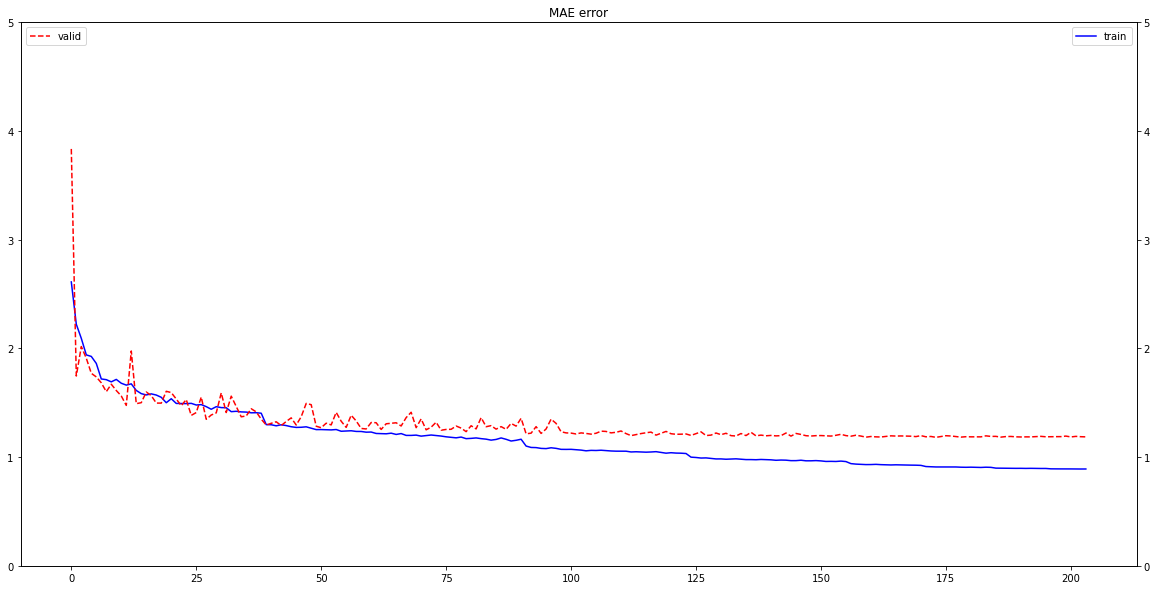

In [49]:
# visualizing
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_mae_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,5)

ax2 = ax1.twinx()
ax2.plot(valid_mae_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,5)

ax1.set_title('MAE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()


In [50]:
# get weights
model = Zloc_Estimaotor(input_dim, hidden_dim,layer_dim)
model.load_state_dict(torch.load('./weights/ODD_LSTM_612_iou4.pth'))
model.eval()
model.to(device)

Zloc_Estimaotor(
  (rnn): LSTM(15, 612, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=612, out_features=294, bias=True)
    (1): ReLU()
    (2): Linear(in_features=294, out_features=146, bias=True)
    (3): ReLU()
    (4): Linear(in_features=146, out_features=72, bias=True)
    (5): ReLU()
    (6): Linear(in_features=72, out_features=1, bias=True)
  )
)

# Predict Train

In [51]:
# predict value
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    train_pred = batch[0]
predict_zloc = model(train_pred.reshape(-1,1,input_dim).to(device))

In [52]:
# get the result
df_train['predict'] = predict_zloc.cpu().detach().numpy()
df_train[['zloc','predict']].head(10)

,zloc,predict
0,33.26,33.377369
1,44.06,44.166389
2,48.93,48.892540
3,53.00,49.797523
4,15.60,15.960265
5,35.56,35.082996
6,17.76,18.502769
7,6.08,6.290573
8,33.44,33.400146
9,20.77,20.068243


In [53]:
# calculate
import numpy as np
abs0 = np.abs(df_train.zloc-df_train.predict)
abs0

0        0.117369
1        0.106389
2        0.037460
3        3.202477
4        0.360265
           ...   
21611    0.085173
21612    0.640209
21613    0.360530
21614    1.404688
21615    2.020979
Length: 21616, dtype: float64

In [54]:
# mae
sum(abs0/len(df_train))

0.9026711600485083

In [55]:
# rmse
np.mean(np.square(df_train['zloc']-df_train['predict']))**(1/2)

1.7234558804978621

In [56]:
# accuracy
func = np.sum(np.abs((df_train.predict - df_train.zloc))/(df_train.predict))
men = func/len(df_train)
1-men

0.9656529279959514

# Predict Valid

In [57]:
# valid set
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(valid_dataloader):
    if idx == 1:
        break
    valid_pred = batch[0]
predict_zloc = model(valid_pred.reshape(-1,1,input_dim).to(device))

In [58]:
# estimate valid
df_valid['predict'] = predict_zloc.cpu().detach().numpy()
df_valid[['zloc','predict']].head(10)

,zloc,predict
0,36.41,35.257492
1,37.96,36.484116
2,11.97,11.469759
3,41.95,47.231674
4,16.34,16.368952
5,4.65,4.988996
6,32.70,32.263947
7,42.93,43.405777
8,57.66,59.439499
9,9.71,8.764616


In [59]:
abs0 = np.abs(df_valid.zloc-df_valid.predict)
abs0

0       1.152508
1       1.475884
2       0.500241
3       5.281674
4       0.028952
          ...   
2697    3.961287
2698    0.042835
2699    0.272183
2700    0.773530
2701    0.349957
Length: 2702, dtype: float64

In [60]:
# mae
sum(abs0/len(df_valid))

1.1824791377107775

In [61]:
#rmse
np.mean(np.square(df_valid['zloc']-df_valid['predict']))**(1/2)

2.0910257118818976

In [82]:
# accuracy
func = np.sum(np.abs((df_valid.predict - df_valid.zloc))/(df_valid.predict))
men = func/len(df_valid)
1-men

0.9541682118413244

# Predict Test

In [83]:
test_mse, test_rmse = evaluate(model, test_dataloader)
print('Test MAE: {:4f} \t Test RMAE: {:4f}'.format(test_mse, test_rmse))

Test MAE: 1.219974 	 Test RMAE: 1.104524


In [84]:
# look dataset
for idx, batch in enumerate(test_dataloader):
    if idx == 1:
        break
    test_pred = batch[0]
predict_zloc = model(test_pred.reshape(-1,1,input_dim).to(device))

In [85]:
df_test['predict'] = predict_zloc.cpu().detach().numpy()
df_test[['zloc','predict']].head(10)

,zloc,predict
0,23.91,23.779802
1,22.08,22.115099
2,17.59,17.544466
3,15.68,15.697229
4,53.67,53.481613
5,14.61,14.675043
6,7.93,7.724176
7,26.44,27.459673
8,50.67,49.509689
9,56.22,58.008438


In [86]:
import numpy as np
abs0 = np.abs(df_test.zloc-df_test.predict)
abs0

0       0.130198
1       0.035099
2       0.045534
3       0.017229
4       0.188387
          ...   
2698    1.441285
2699    0.259637
2700    0.233844
2701    0.611654
2702    0.183987
Length: 2703, dtype: float64

In [87]:
# mae
sum(abs0/len(df_test))

1.2199737735717264

In [88]:
# rmse
np.mean(np.square(df_test['zloc']-df_test['predict']))**(1/2)

2.2415832764287247

### 구간 나눠서 정확도 계산해보기
## Divide by distance range and calculate it

In [69]:
first = df_test[df_test['zloc']<=10]
func1 = np.sum(np.abs((first.predict - first.zloc))/(first.predict))
men1 = func1/len(first)
1-men1

0.9292780413215092

In [70]:
mask = (df_test['zloc']>=10) & (df_test['zloc']<20)
second = df_test[mask]
func2 = np.sum(np.abs((second.predict - second.zloc))/(second.predict))
men2 = func2/len(second)
1-men2

0.9641430964021086

In [71]:
mask = (df_test['zloc']>=20) & (df_test['zloc']<30)
third = df_test[mask]
func3 = np.sum(np.abs((third.predict - third.zloc))/(third.predict))
men3 = func3/len(third)
1-men3

0.9617308826919295

In [72]:
mask = (df_test['zloc']>=30) & (df_test['zloc']<40)
fourth = df_test[mask]
func4 = np.sum(np.abs((fourth.predict - fourth.zloc))/(fourth.predict))
men4 = func4/len(fourth)
1-men4

0.9536270769034572

In [73]:
mask = (df_test['zloc']>=40) & (df_test['zloc']<50)
fifth = df_test[mask]
func5 = np.sum(np.abs((fifth.predict - fifth.zloc))/(fifth.predict))
men5 = func5/len(fifth)
1-men5

0.9511991349365575

In [74]:
mask = (df_test['zloc']>=50) & (df_test['zloc']<60)
sixth = df_test[mask]
func6 = np.sum(np.abs((sixth.predict - sixth.zloc))/(sixth.predict))
men6 = func6/len(sixth)
1-men6

0.9451811834911445

In [75]:
mask = (df_test['zloc']>=60) & (df_test['zloc']<70)
seventh = df_test[mask]
func7 = np.sum(np.abs((seventh.predict - seventh.zloc))/(seventh.predict))
men7 = func7/len(seventh)
1-men7

0.9375939088662171

In [100]:
acc_list = []
for i in range(1,12):
    mask = (df_test['zloc']<i*10) & (df_test['zloc'] >= i)
    data = df_test[mask]
    value = np.sum(np.abs((data.predict - data.zloc))/(data.predict))
    output = value/len(data)
    acc_list.append(1-output)

In [101]:
acc_list

[0.9292222695942318,
 0.9508433121692339,
 0.9557812313803546,
 0.9581238858258856,
 0.9586695839802325,
 0.9581438641884256,
 0.9578240488203149,
 0.9574140710112151,
 0.9571890215935799,
 0.957026402758832,
 0.9569121436323509]

# Visualization

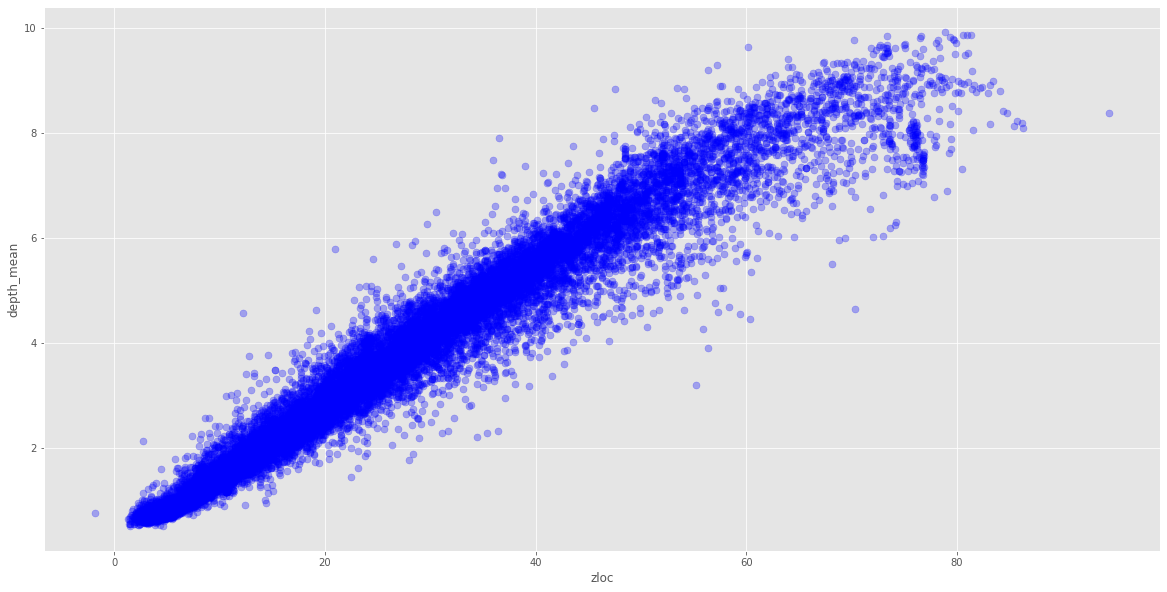

In [95]:
df_train.plot(kind='scatter', x='zloc', y='depth_mean', marker='o', alpha=0.3, s=50, figsize=(20,10), color='blue')
plt.show()

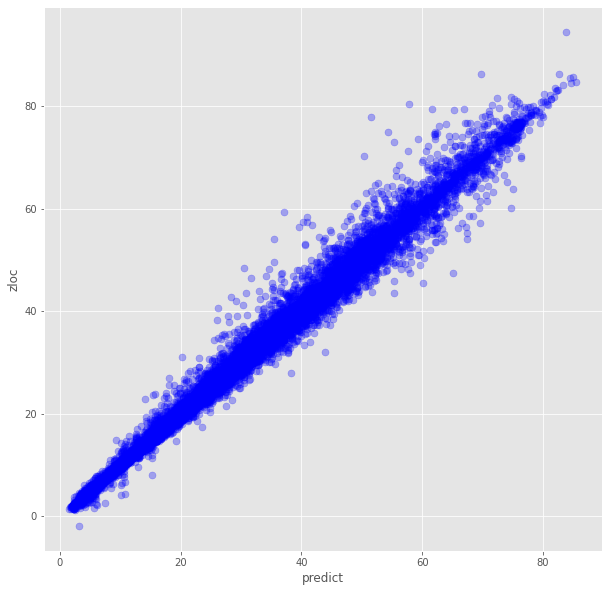

In [96]:
df_train.plot(kind='scatter', x='predict', y='zloc', marker='o', alpha=0.3, s=50, figsize=(10,10), color='blue')
plt.show()

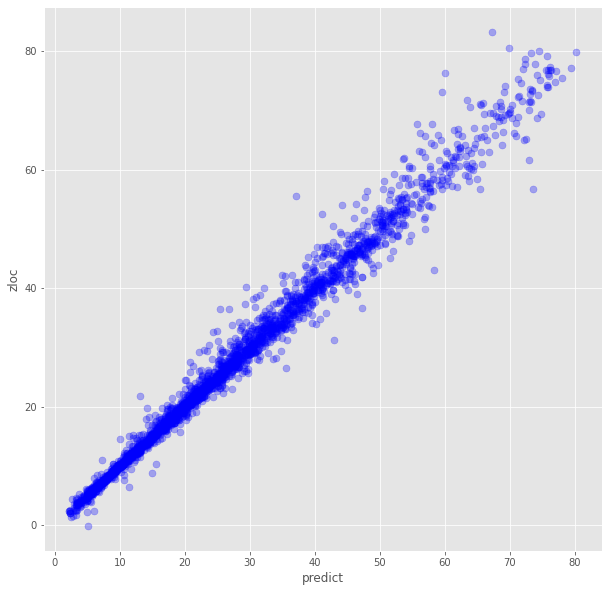

In [97]:
df_valid.plot(kind='scatter', x='predict', y='zloc', marker='o', alpha=0.3, s=50, figsize=(10,10), color='blue')
plt.show()

<AxesSubplot:xlabel='predict', ylabel='zloc'>

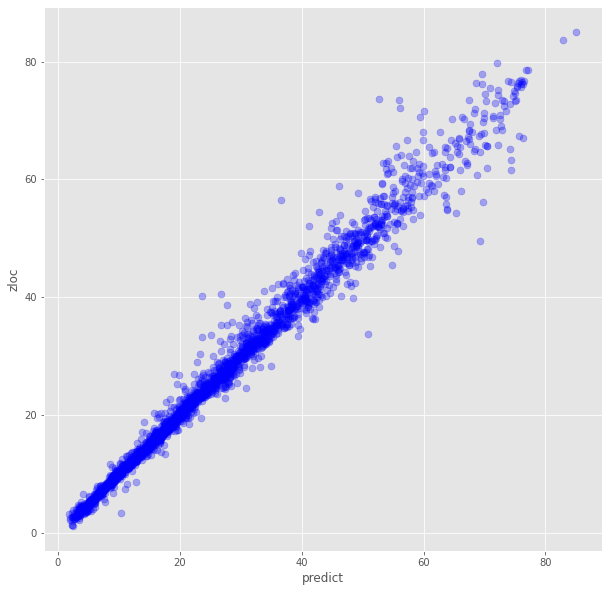

In [98]:
df_test.plot(kind='scatter', x='predict', y='zloc', marker='o', alpha=0.3, s=50, figsize=(10,10), color='blue')